<a href="https://colab.research.google.com/github/Siddhant254/Shoppin-Project/blob/main/CNN_Based_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow matplotlib scikit-learn


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# Download Tiny ImageNet dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2025-01-27 15:05:08--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-27 15:05:09--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.85MB/s    in 31s     

2025-01-27 15:05:40 (7.60 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [5]:
# Define paths
base_path = "tiny-imagenet-200"
train_path = os.path.join(base_path, "train")

# Preprocess the images for ResNet50
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode=None,  # We only need the images, not the labels
    shuffle=False
)

# Store image paths for visualization
image_paths = [os.path.join(train_path, fname) for fname in train_generator.filenames]


Found 100000 images belonging to 200 classes.


In [6]:
# Load ResNet50 without the top layer (pretrained on ImageNet)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features for all images
features = model.predict(train_generator, verbose=1)
print("Extracted features shape:", features.shape)  # (number_of_images, feature_vector_size)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 162ms/step
Extracted features shape: (100000, 2048)


In [7]:
# Fit KNN on extracted features
knn = NearestNeighbors(n_neighbors=5, metric="cosine")  # Using cosine similarity
knn.fit(features)


NearestNeighbors(metric='cosine')

In [8]:
def show_similar_images(query_image_path, model, knn, image_paths):
    """
    Perform image similarity search using the query image.

    Args:
        query_image_path (str): Path to the query image.
        model (keras.Model): Pretrained feature extractor.
        knn (NearestNeighbors): Trained KNN model.
        image_paths (list): List of image paths for visualization.
    """
    # Load and preprocess the query image
    query_image = load_img(query_image_path, target_size=(224, 224))
    query_array = img_to_array(query_image)
    query_array = preprocess_input(query_array)
    query_array = np.expand_dims(query_array, axis=0)

    # Extract features for the query image
    query_features = model.predict(query_array)

    # Find similar images using KNN
    distances, indices = knn.kneighbors(query_features)

    # Plot the query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis("off")

    # Plot the similar images
    for i, idx in enumerate(indices[0]):
        similar_image = load_img(image_paths[idx])
        plt.subplot(1, 6, i + 2)
        plt.imshow(similar_image)
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


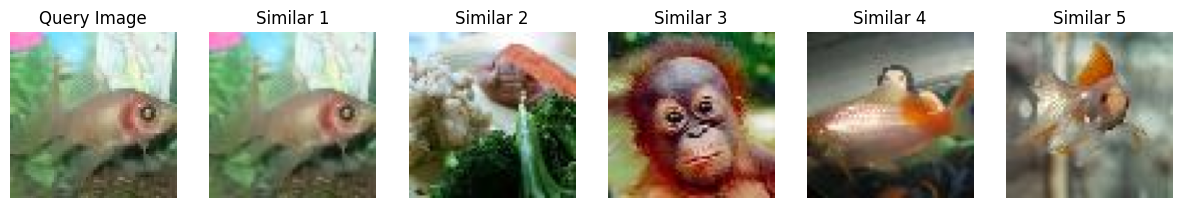

In [9]:
# Path to a query image from the dataset
query_image_path = os.path.join(train_path, "n01443537/images/n01443537_0.JPEG")

# Display similar images
show_similar_images(query_image_path, model, knn, image_paths)
